# Backlog Forecasting - non-equilibrium

Fitting data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

This note is about forecasting in a non-equilibirum situation. It illustrates how this manifests itself and how to identify a (sub)period of equilibrium.

The data used in this note exhibits two 'difficulties':

1. it is a sequence of throughput data with a changing delivery rate,
1. the number of data points is much less than the number of categories ($x$-range).

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Preparation](#Preparation)
* [Simple forecast using the empirical data](#Simple-forecast-using-the-empirical-data)
* [First attempt to fit the data using a Poisson distribution](#First-attempt-to-fit-the-data-using-a-Poisson-distribution)
* [Second attempt](#Second-attempt)
* [Forecasting using a Poisson distribution](#Forecasting-using-a-Poisson-distribution)
* [Total Monte Carlo](#Total-Monte-Carlo)
* [References](#References)

## Set-up

In [1]:
require Chi2fit.Distribution
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Gnuplot, as: G
alias Exboost.Math

Exboost.Math

## Data and simulation set-up

As an example consider the throughput of completed backlog items. At the end of a fixed time period we count the number of backlog items that a team completes. Partially completed items are excluded from the count.

The following is such a sequence with the count corresponding to the most recent date as the first item.

In [2]:
data = [53, 50, 53, 48, 69, 39, 12, 17, 21, 15, 15, 31, 62, 78, 23, 17, 25, 28, 38, 16]

[53, 50, 53, 48, 69, 39, 12, 17, 21, 15, 15, 31, 62, 78, 23, 17, 25, 28, 38, 16]

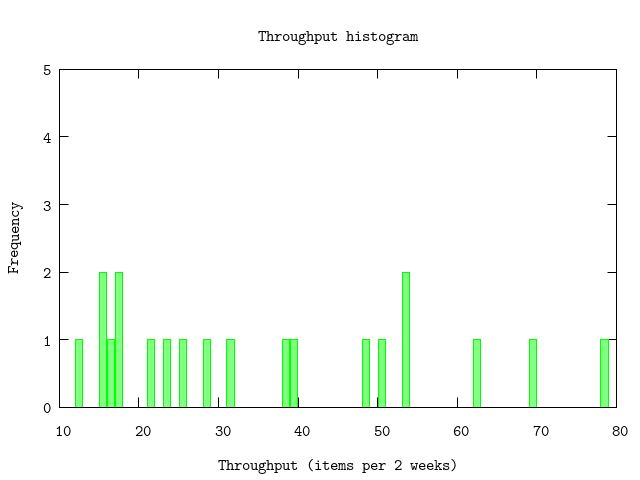

In [3]:
P.histogram(data,
    plottitle: "Throughput histogram",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Frequency",
    yrange: '[0:5]')
:"this is an inline image"

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

In [4]:
# The size of the backlog, e.g. 100 backlog items
size = 1000

# The time period (in days) that the throughput data is collected
period = 15

# The size of the bins (number of periods)
binsize = 5

# Number of iterations to use in the Monte Carlo
iterations = 1000

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = [{1,100}]

[{1, 100}]

## Preparation

Next, we convert the throughput data to a histogram. To this end we group the data in bins of size 5 starting at 0.

__Note__. Here, we have grouped the data in bins of size 5. This is a bit of experimentation. A too small bin size will give many categories but with a few events per bin. This results is a large error per bin. On the other hand, a larger bin size provides more events per bin and a relatively smeller error but with less categories and therefore less data points to fit a distribution.

In [5]:
hdata = U.to_bins data, {binsize,0}

[{15, 0.15, 0.06851192859049528, 0.27482375992342073}, {20, 0.3, 0.18768957690362428, 0.43588026413027636}, {25, 0.45, 0.3206378385081606, 0.5851694522985315}, {30, 0.5, 0.36721150008242087, 0.6327884999175791}, {35, 0.55, 0.41483054770146854, 0.6793621614918394}, {40, 0.65, 0.513235780746243, 0.7692135974636096}, {50, 0.75, 0.6162610054750528, 0.8539648329961009}, {55, 0.85, 0.7251762400765793, 0.9314880714095048}, {65, 0.9, 0.7827976428762097, 0.9656975423431892}, {70, 0.95, 0.8438262671806204, 0.993275152469804}, {80, 1.0, 0.9114867522921007, 1.0}]

The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

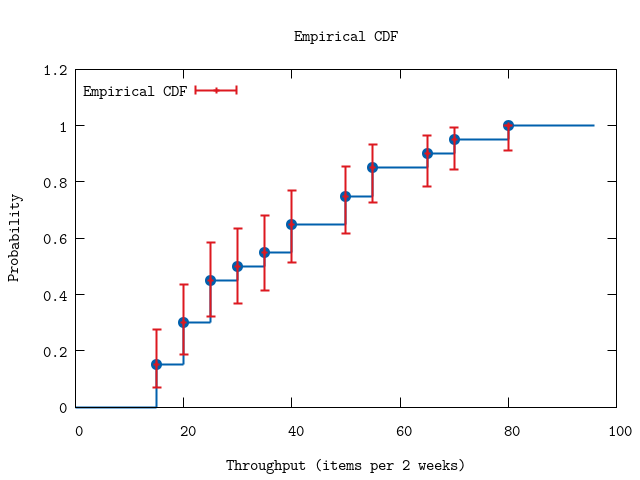

In [6]:
P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:100]')
:"this is an inline image"

## Simple forecast using the empirical data

Using the histogram data for the throughput we perform a Monte Carlo simulation to get an estimation for the number of iterations needed to deplete the backlog. Since for a large enough number of samples results of a Monte Carlo simulation approximate the normal distribution. This provides a range for the uncertainty of the number of iterations. We express this as a probability using percentages.

In [7]:
{avg,sd,all} = U.mc iterations, U.forecast_duration(data, size), collect_all?: true
U.display {avg,sd,:+}

50%    => 29.0 units
84%    => 32.0 units
97.5%  => 35.0 units
99.85% => 38.0 units


:ok

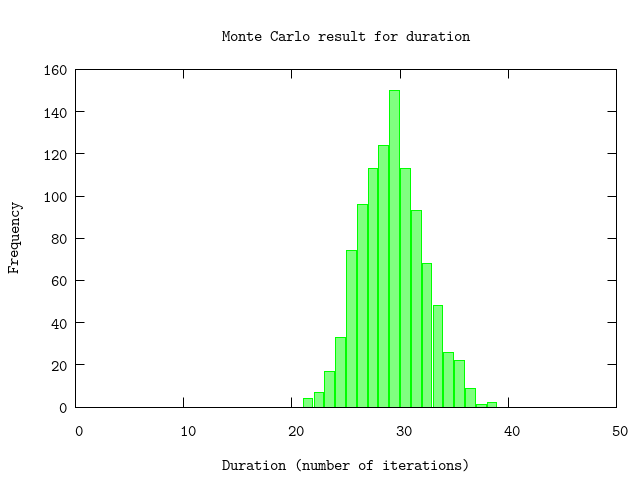

In [8]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration",
    xlabel: "Duration (number of iterations)",
    ylabel: "Frequency",
    xrange: '[0:50]')
:"this is an inline image"

## First attempt to fit the data using a Poisson distribution

Instead of directly using the raw data captured one can also use a known probability distribution. The parameter of the distribution is matched to the data. After matching the parameter value one uses the known distribution to forecast.

Here, we will use the __Poisson distribution__ [1]. This basically assumes that the data points are independent of each other. For most teams we expect this to be a more than reasonable choice.

In [9]:
model = D.model {"poisson",period}
options = [probes: probes, smoothing: false, model: :linear, saved?: true]

[probes: 10000, smoothing: false, model: :linear, saved?: true]

The code below uses basic settings of the commands provided by `Chi2Fit`. More advanced options can be found at [2]. First a fixed number of random parameter values are tried to get a rough estimate. The option `probes` equals the number of tries. Furthermore, since we are fitting a probability distribution which has values on the interval `[0,1]` the errors are asymmetrical. This is specified by the option `linear`. 

In [10]:
result = {_,_parameters,_,_saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		756551.257890296
    pars:		[2.2455026244148724]
    ranges:		{[2.2455026244148724, 2.2455026244148724]}



:ok

The result shows a very high value of the Chi-squared statistic at the minimum. This is a first indication that a Poisson distribution does not describe our team's data very well. This is surprising and not what we would expect.

Let's try to figure out what is going on.

## Analysis

To analyse the team's throughput data we start with the most recent throughput data point and each time add a data point until we reach the end. Doing this we form a sequence of data points where at every step the new sequence is one item longer than the previous sequence.

For each such formed subsequence we run a fit against the Poisson distribution. The result is shown below.

In [21]:
history = 0..length(data)-1
|> Stream.map(fn i ->
        data
        |> Enum.slice(0..i)
        |> U.to_bins({binsize,0})
        |> F.chi2probe(initial, {Distribution.cdf(model), &F.nopenalties/2}, options)
    end)
|> Stream.map(fn {chi,[par],_,_} -> {chi,par} end)
|> Enum.with_index()

history
|> Enum.map(fn {{chi,rate},index} -> [index, Float.round(chi,2), Float.round(rate,1)] end)
|> U.as_table({"Index data point", "Chi-squared", "Delivery Rate"})
:"do not show this result in output"

Index data point|Chi-squared|Delivery Rate
----------------|-----------|-------------
0               |0.0        |1.0          
1               |0.02       |3.2          
2               |0.18       |3.3          
3               |0.14       |3.2          
4               |0.04       |3.4          
5               |0.04       |3.3          
6               |25542.73   |2.3          
7               |19578.69   |2.3          
8               |15343.66   |2.3          
9               |91654.1    |2.2          
10              |170835.38  |2.1          
11              |141687.38  |2.1          
12              |558828.78  |2.2          
13              |1588446.35 |2.2          
14              |1369507.77 |2.2          
15              |1200462.27 |2.3          
16              |1056299.19 |2.2          
17              |938423.21  |2.2          
18              |838336.56  |2.3          
19              |756455.49  |2.2          


Next, we plot the results for each subsequence. We get two sets of data points corresponding to the value of chi-squared at the minimum and the value for the fitted delivery rate.

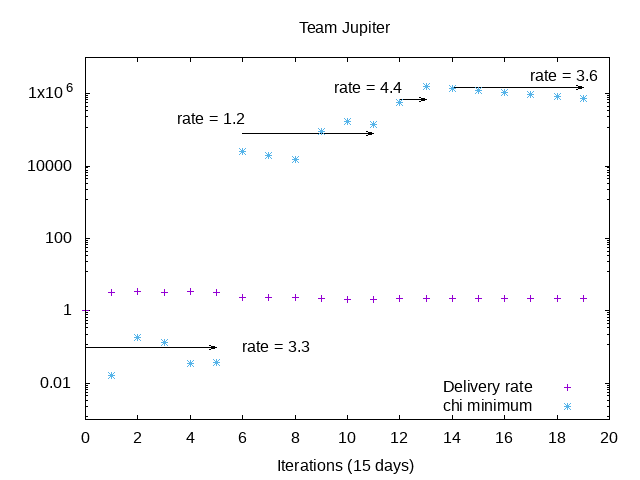

In [55]:
G.plot([
    ~w(set terminal png)a,
    ~w(set output)a,
    ~w(set title "Team Jupiter")a,
    ~w|set xlabel "Iterations (15 days)"|a,
    ~w(set key bottom right)a,
    [:set, :yrange, '[0.001:10000000]'],
    ~w(set arrow from 0,0.1 to 5,0.1)a,
    ~w(set label "rate = 3.3" at 6,0.1)a,
    ~w(set arrow from 6,80000 to 11,80000)a,
    ~w(set label "rate = 1.2" at 3.5,200000)a,
    ~w(set arrow from 12,700000 to 13,700000)a,
    ~w(set label "rate = 4.4" at 9.5,1400000)a,
    ~w(set arrow from 14,1500000 to 19,1500000)a,
    ~w(set label "rate = 3.6" at 17,3000000)a,
    ~w(set logscale y)a,
    [:plot, G.list([
            ~w|'-' u 1:2 w points ls 1 title "Delivery rate"|a,
            ["", :u, '1:2', :w, :points, :ls, 3, :title, "chi minimum"]
        ])
    ]
  ],
  [
      history |> Enum.map(fn {{_,rate},x} -> [x,rate] end),
      history |> Enum.map(fn {{chi,_},x} -> [x,chi] end)
  ])
P.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

The graph above shows the logarithm of the chi-squared at the minimum as the blue stars. This clearly shows jumps at the sixth, ninth, and twelth data points. The same is true for the delivery rate although this is most evident at the sixth data point!

This shows that the most probable explanation is that the delivery rate is not constant for the team over time.
One of the assumptions for ther Poisson distribution to describe the data is a constant delivery rate [1], i.e. the delivery rate does not change over time.

If we take the 5 most recent data points we can fit this with a Poisson distribution. The downside is that we loose many of our data points resulting in a large error on the fitted delivery rate.

### Automated

Luckily, `Chi2fit` provides a function that automates the finding of the jumps in how well a distribution is able to describe our data.

In [13]:
trends = F.find_all(data, [{:bin,binsize}, {:fitmodel, model}, {:init, initial} |options])

[{0.036298739064136686, [3.3105360191533375], '5250E\''}, {0.6734317357994228, [1.1964637990990683], [12, 17, 21, 15, 15, 31]}, {5.800820523615346e-4, [4.3540473193510625], '>N'}, {0.04491801200236626, [1.578301449162081], [23, 17, 25, 28, 38, 16]}]

`F.find_all` returns a list of tuples. Each tuple includes the elements:

1. value of chi-squared at the found minimum,
1. list of parameter values at the minimum,
1. subsequence of data

## Second attempt

We take a subset of the original data set, namely the most recent 6 data points.

In [14]:
# Extract the most recent data sequence from the head of `trends`
{_,_,data} = hd trends
hdata = U.to_bins data, {binsize,0}

[{40, 0.16666666666666666, 0.02262494120997527, 0.45322913427940825}, {50, 0.5, 0.24185253403145093, 0.7581474659685491}, {55, 0.8333333333333334, 0.5467708657205917, 0.9773750587900247}, {70, 1.0, 0.7369106554956896, 1.0}]

## Forecasting using a Poisson distribution

First, run an initial fit to get an estimate of the parameters.

In [15]:
result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		0.03658634067587007
    pars:		[3.303671412343659]
    ranges:		{[3.0710423614985243, 3.5658573339602837]}



:ok

The errors reported is the found range of parameter values where the corresponding `chi2` values are within 1 of the found minimum value.

After roughly locating the minimum we do a more precise (and computationally more expensive) search for the minimum.

In [16]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 100, options
U.display(hdata,model,result,options)

Final:
    chi2:		0.03628574276222343
    Degrees of freedom:	3
    gradient:		[-6.2495214917223885e-12]
    parameters:		[3.309353062586756]
    errors:		[0.32807215518642774]
    ranges:
			chi2:		0.03628574276222343	-	1.0090360306540513
			parameter:	3.0710423614985243	-	3.5658573339602837


:ok

For a (local) minimum the value of the gradient should be very close to zero which is the case. The value of chi-squared at the minimum is much, much smaller than 1. Usually values below 1 indicate a very good fit. Large errors on the data make it easy to fit a curve resulting in low values for chi-squared. Here, it means that the errors in the data are large.

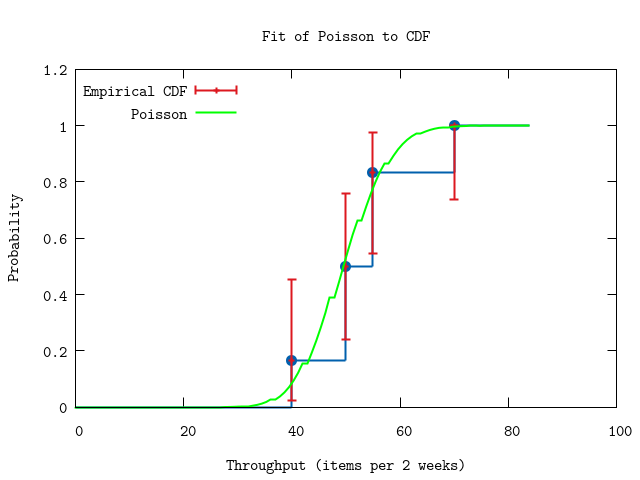

In [17]:
P.ecdf(hdata,
    plottitle: "Fit of Poisson to CDF",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:100]',
    title: "Poisson",
    func: & Distribution.cdf(model).(&1,parameters))
:"this is an inline image"

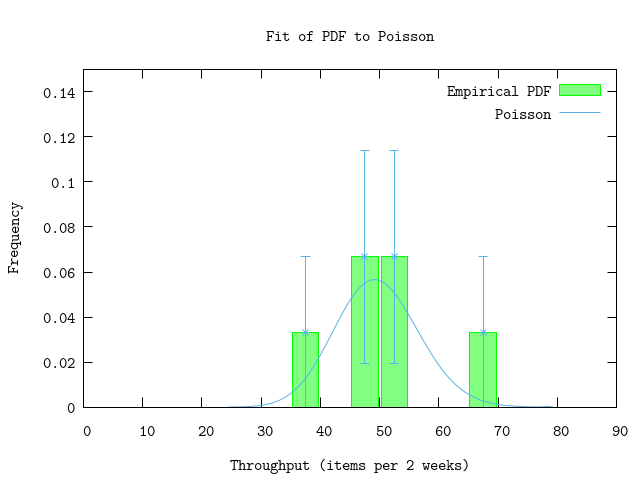

In [20]:
rate = hd(parameters)
pdf = fn x -> :math.exp(x*:math.log(rate*period)-rate*period-Math.lgamma(x+1.0)) end
P.pdf(data,
    plottitle: "Fit of PDF to Poisson",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Frequency",
    yrange: '[0:0.15]',
    pdf: pdf,
    title: "Poisson",
    bin: binsize)
:"this is an inline image"

Again, using a Monte Carlo simulation we estimate the number of iterations and the range to expect.

In [21]:
[rate] = parameters
{avg,sd,all} = U.mc iterations, fn -> U.forecast(fn -> Distribution.random(model).(parameters) end, size) end, collect_all?: true
U.display {avg,sd,:+}

50%    => 21.0 units
84%    => 22.0 units
97.5%  => 22.0 units
99.85% => 23.0 units


:ok

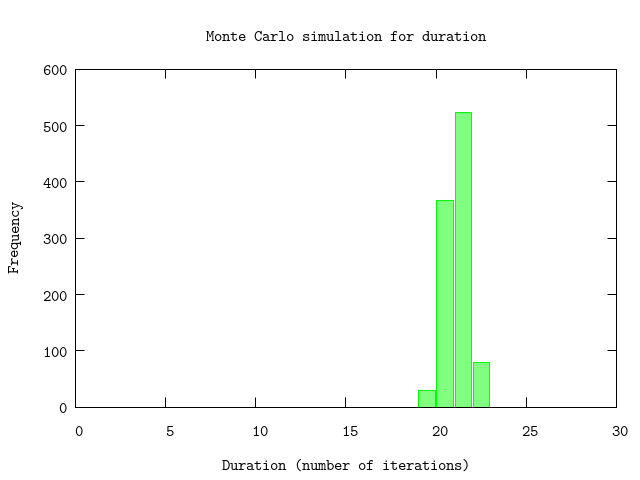

In [22]:
P.histogram(all,
    plottitle: "Monte Carlo simulation for duration",
    xlabel: "Duration (number of iterations)",
    ylabel: "Frequency",
    xrange: '[0:30]')
:"this is an inline image"

## Total Monte Carlo

In the results of a Monte Carlo simulation the errors reported and the range of the number of iterations is the statistical error associated with the Monte Carlo simulation. It dopes not take into account the uncertainty of the parameter used in the fitted probability distribution function.

In Total Monte Carlo [4] multiple Monte Carlo simulations are done that correspond to the extreme values of the error bounds of the used parameters. The error results is of a different nature than the statistical error from the Monte Carlo simulation. These error reported separately.

In [23]:
# Pick up the error in the paramater value
param_errors = cov |> M.diagonal |> Enum.map(fn x->x|>abs|>:math.sqrt end)
[sd_rate] = param_errors

{avg_min,_} = U.mc(iterations, fn -> U.forecast(fn -> Distribution.random(model).([rate-sd_rate]) end, size) end)
{avg_max,_} = U.mc(iterations, fn -> U.forecast(fn -> Distribution.random(model).([rate+sd_rate]) end, size) end)

sd_min = avg - avg_max
sd_plus = avg_min - avg

IO.puts "Number of iterations to complete the backlog:"
IO.puts "#{Float.round(avg,1)} (+/- #{Float.round(sd,1)}) (-#{Float.round(sd_plus,1)} +#{Float.round(sd_min,1)})"

Number of iterations to complete the backlog:
20.7 (+/- 0.7) (-2.2 +1.8)


:ok

The first error is symmetric while the second error reported is asymmetric.

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf